In [1]:
# conda: holo37 xesmfTools

# For local installations:
# cd to the 'lib' directory in your notebooks directory
# $ export LIBROOT=`pwd`
# Start jupyter lab from any directory and open this application

import sys, os
if (os.environ.get('LIBROOT')):
    sys.path.append(os.environ.get('LIBROOT'))
else:    
    # Detect use of this notebook in mybinder.org
    cDir = os.getcwd()
    if cDir == '/home/jovyan/gridTools':
        sys.path.append('/home/jovyan/gridTools/lib')

#from sysinfo import SysInfo
#info = SysInfo()
#info.show(vList=['platform','python','esmf','esmpy','xgcm','xesmf',
#                 'netcdf4','numpy','xarray',
#                 'cartopy','matplotlib',
#                 'jupyter_core','jupyterlab','notebook',
#                 'dask','panel'])

# import gridutils.py from local folder via LIBROOT path specified above
from gridutils import GridUtils
import numpy as np
import cartopy.crs as ccrs
import os, sys, io
import cartopy
import matplotlib.pyplot as plt
import netCDF4 as nc
import warnings
import xarray as xr
try:
    import xgcm
except:
    print("The module xgcm is not loaded.")
from io import BytesIO
import pdb
warnings.filterwarnings('ignore')

import panel as pn
pn.extension()

In [2]:
# Globals

# How we grow the grid from the specified latitude (lat0) or longitude (lon0)
# TODO: If 'Center' is not chosen then the controls for Central Latitude and Central Longitude no longer make sense.
# For now: we assume Center/Center for making grids.
xGridModes = ['Left', 'Center', 'Right']
yGridModes = ['Lower', 'Center', 'Upper']

# For now only MOM6 works.  It could work for other grids!
#gridTypes = ["MOM6", "ROMS", "WRF"]
gridTypes = ["MOM6"]

# Available plot projections
plotProjections = ["Nearside Perspective", "Mercator", "Lambert Conformal Conic", "North Polar Stereographic", "South Polar Stereographic"]
plotProjectionsGridTools = ["NearsidePerspective", "Mercator", "LambertConformalConic", "NorthPolarStereo", "SouthPolarStereo"]
plotProjectionsDict = dict(zip(plotProjections, plotProjectionsGridTools))

# Supported grid projections
projNames = ["Mercator", "Lambert Conformal Conic", "North Polar Stereographic", "South Polar Stereographic"]
gridToolNames = ["Mercator", "LambertConformalConic", "NorthPolarStereo", "SouthPolarStereo"]
projNamesGridTools = dict(zip(projNames, gridToolNames))
projCarto = [ccrs.Mercator(), ccrs.LambertConformal(),  ccrs.NorthPolarStereo()]
projDict = dict(zip(projNames,projCarto))

# Plot grid modes
# gridExtent, gridCells, superGrid
plotGridModes = ['gridExtent', 'gridCells', 'superGrid']
plotGridModesDescriptions = ['Grid Extent', 'Grid Cells', 'Supergrid Cells']
plotGridModeDict = dict(zip(plotGridModesDescriptions, plotGridModes))

plotColors = ['b', 'c', 'g', 'k', 'm', 'r', 'y']
plotColorsDescriptions = ['Blue', 'Cyan', 'Green', 'Black', 'Magenta', 'Red', 'Yellow']
plotColorDict = dict(zip(plotColorsDescriptions, plotColors))

plotLineStyles = ['solid', 'dotted', 'dashed', 'dashdot']
plotLineStylesDescriptions = ['Solid', 'Dotted', 'Dashed', 'DashDot']
plotLineStyleDict = dict(zip(plotLineStylesDescriptions, plotLineStyles))

# This controls the default figure size of the plot in the panel application
# TODO: Improve integration
# aspect 4:3, default dpi=144
widthIn = 5.0
heightIn = (widthIn * 3.0) / 4.0
defaultPlotFigureSize = (widthIn, heightIn)

# plotWidgetWidth and plotWidgetHeight
# used by other controls
plotWidgetWidth = 800
plotWidgetHeight = 600

# Initialization

# This needs to exist prior to calling make_plot() in the panel application
grd = GridUtils()

In [3]:
# Panel application functions

def updateDataView():
    dataView[0] = grd.grid
    return
    
def updateFilename(newFilename):
    gridFilenameLocal.value = newFilename
    gridFilenameRemote.value = newFilename
    return

def downloadNetCDF():
    # See if we have a race condition
    saveLocalGridButton.filename = gridFilenameLocal.value
    bout = grd.grid.to_netcdf()
    bio = BytesIO()
    bio.write(bout)
    bio.seek(0)
    return bio

def loadLocalGrid(event):

    if localFileSelection.value == None:
        statusWidget.value = "A grid file has not been selected in the Local File tab."
        return

    # Test to see if xarray can load the selected file
    try:
        ncTest = xr.load_dataset(localFileSelection.value)
        statusWidget.value = "The grid file %s was loaded." % (localFileSelection.filename)
        grd.clearGrid()
        grd.readGrid(local=ncTest, localFilename=localFileSelection.filename)
        updateDataView()
        updateFilename(localFileSelection.filename)
    except:
        statusWidget.value = "The grid file %s was not loadable." % (localFileSelection.filename)

    return
    
def loadRemoteGrid(event):
    
    ct = len(remoteFileSelection.value)

    if ct == 0:
        statusWidget.value = "A grid file has not been selected in the Remote File tab."
        return
    
    try:
        fileToOpen = remoteFileSelection.value[0]
        grd.openDataset(remoteFileSelection.value[0])
        grd.readGrid()
        statusWidget.value = "The grid file %s was loaded." % (fileToOpen)
        updateDataView()
        updateFilename(fileToOpen)
    except:
        statusWidget.value = "Failed to load grid file: %s" % (fileToOpen)
    
    return

def saveRemoteGrid(event):
    '''Attempt to save grid to remote filesystem using last known grid filename.'''
    grd.saveGrid(filename=gridFilenameRemote.value)

def make_grid(event):
    statusWidget.value = "Running make_grid()"
    grd.clearGrid()
    grd.setGridParameters({
        'projection': {
            'name': projNamesGridTools[gridProjection.value],
            'lon_0': float(glon0.value),
            'lat_0': float(glat0.value)
        },
        'dx': int(dx.value),
        'dy': int(dy.value),
        'dxUnits': 'degrees',
        'dyUnits': 'degrees',    
        'gridResolution': float(gridResolution.value),
        'gridMode': float(gridMode.value),
        'tilt': float(gtilt.value)
    })
    grd.makeGrid()

    # Update the plot if we updated the grid
    plotWindow.object = make_plot()
    
    # Update grid info
    updateDataView()
    
    return

def make_plot():
    statusWidget.value = "Running make_plot()"
    
    if plotTitle.value != "":
        mp_title = plotTitle.value
    else:
        selectedProjection = plotProjection.value
        mp_title = "%s: " % (selectedProjection) + str(dx.value) + "x" + str(dy.value) + " with " + str(gtilt.value) + " degree tilt"
    
    # Check plotGridMode.value to set plot parameter showGridCells
    showGridCellsState = False
    pGridMode = plotGridModeDict[plotGridMode.value]
    if pGridMode == 'gridCells':
        showGridCellsState = True
    
    # Determine plot extent
    plotExtentState = []
    # If we are not using the global projection, use the user supplied extents
    if not(plotUseGlobal.value):
        x0pt = plotExtentX0.value
        # May or maynot need this?
        if x0pt > 180.0:
            x0pt = x0pt - 360.0
        x1pt = plotExtentX1.value
        if x1pt > 180.0:
            x1pt = x1pt - 360.0

        plotExtentState = [x0pt, x1pt,
                          plotExtentY0.value, plotExtentY1.value]
    
    grd.setPlotParameters(
        {
            'figsize': defaultPlotFigureSize,
            'projection' : {
                'name': plotProjectionsDict[plotProjection.value],
                'lat_0': float(plat0.value),
                'lon_0': float(plon0.value)
            },
            'extent': plotExtentState,
            'iLinewidth': plotXLineWidth.value,
            'jLinewidth': plotYLineWidth.value,
            'showGridCells': showGridCellsState,
            'title': mp_title,
            'iColor': plotColorDict[plotXColor.value],
            'jColor': plotColorDict[plotYColor.value]
        }
    )
    if grd.xrOpen:
        (figure, axes) = grd.plotGrid()
    else:
        figure = grd.newFigure()
        statusWidget.value = "Running make_grid(): plotting failure"

    return figure

def plotRefresh(event):
    plotWindow.object = make_plot()
    return
    
def showManual():
    manualTabs = pn.Tabs()
 
    pageMain = pn.WidgetBox('''
    # Instructions
    This will be the eventual location for the instruction manual.
    ''', width=plotWidgetWidth)
    
    pageGrids = pn.WidgetBox('''
    # Grids
    ***We love grids!***
    ## Grid Reference
    This controls how the grid is grown from the selected latitude (lat0) and longitude (lon0) using
    degrees or x (x0) or y (y0) using meters.  By default, the grid is grown from the center point
    in both directions based on the size (dy, dx) and grid resolution.  In the future, grids may
    be build with other fixed points of reference.
    
    ## Grid Type
    For now, only MOM6 is supported.  Other grid types may be possible in the future.
    
    ## Grid Mode
    Internally, this mode is 2 which really means computations
    are done to compute vertices for the grid cells and vertices through the center points of the
    grid cells.  At present, this mode should not be anything other than 2 for MOM6 grids.
    
    ## Grid Representation
    Here is a representation of a (2,3) MOM6 grid from convert_ROMS_grid_to_MOM6.py
    by Mehmet Ilicak and Alistair Adcroft.
    
    ```
     3    + | + | + | +
          - p - p - p -
     2    + | + | + | +
          - p - p - p -
     1    + | + | + | +
 
          1   2   3   4
          
    KEY: p = rho (center) points
         + = psi (corner) points
         - = u points
         | = v points
    ```
          
    A MOM6 grid of (ny, nx) will have (ny\*2+1, nx\*2+1) points on the supergrid.
    ''', width=plotWidgetWidth)

    manualTabs.extend([
        ('Main', pageMain),
        ('Grids', pageGrids)
    ])

    return manualTabs

In [4]:
# Construct panel application

In [5]:
# Widgets
statusWidget = pn.widgets.TextAreaInput(name='Information', value="", background="skyblue", height=100)

# Grid Controls
# Use: Niki's defaults for rapid testing
# 30x20 tilt 30 deg lat_0 40.0 lon_0 230.0 Res 1.0
gridProjection = pn.widgets.Select(name='Projection', options=projNames, value=projNames[1])
gridType = pn.widgets.Select(name="Grid Type", options=gridTypes, value=gridTypes[0])
gridType.disabled = True
gridResolution = pn.widgets.Spinner(name="Grid Resolution", value=1.0, step=0.1, start=0.0, end=10.0, width=80)
gridMode = pn.widgets.Spinner(name="Grid Mode", value=2, step=1, start=1, end=2, width=80)
gridMode.disabled = True
unitNames = ['degrees','meters']
dxdyUnits = pn.widgets.Select(name='Units', options=unitNames, value=unitNames[0])
dx = pn.widgets.Spinner(name="dx", value=20, step=1, start=0, end=100, width=100)
dy = pn.widgets.Spinner(name="dy", value=30, step=1, start=0, end=100, width=100)
glon0 = pn.widgets.Spinner(name="Central Longitude(lon_0) (0 to 360)", value=230, step=1, start=0, end=360, width=100)
glat0 = pn.widgets.Spinner(name="Central Latitude(lat_0) (-90 to 90)", value=40, step=1, start=-90, end=90, width=100)
glat1 = pn.widgets.Spinner(name="First Parallel(lat_1) (-90 to 90)", value=40, step=1, start=-90, end=90, width=100)
glat2 = pn.widgets.Spinner(name="Second Parallel(lat_2) (-90 to 90)", value=40, step=1, start=-90, end=90, width=100)
glatts = pn.widgets.Spinner(name="Latitude of True Scale(lat_ts) (-90 to 90)", value=40, step=1, start=-90, end=90, width=100)
gtilt = pn.widgets.Spinner(name="Tilt (-90 to 90)", value=30.0, step=0.1, start=-90, end=90, width=100)
gridControlUpdateButton = pn.widgets.Button(name='Make Grid', button_type='primary')
gridControlUpdateButton.on_click(make_grid)
xGridControl = pn.widgets.Select(name='X grid mode', options=xGridModes, value=xGridModes[1])
yGridControl = pn.widgets.Select(name='Y grid mode', options=yGridModes, value=yGridModes[1])

# Plot Controls
# Use Niki's defaults for rapid testing
# extent: -160, -100, 60, 20

# Projection
plotProjection = pn.widgets.Select(name='Projection', options=plotProjections, value=plotProjections[0])
plon0 = pn.widgets.Spinner(name="Central Longitude(lon_0) (0 to 360)", value=230, step=1, start=0, end=360, width=100)
plat0 = pn.widgets.Spinner(name="Central Latitude(lat_0) (-90 to 90)", value=40, step=1, start=-90, end=90, width=100)
plat1 = pn.widgets.Spinner(name="First Parallel(lat_1) (-90 to 90)", value=40, step=1, start=-90, end=90, width=100)
plat2 = pn.widgets.Spinner(name="Second Parallel(lat_2) (-90 to 90)", value=40, step=1, start=-90, end=90, width=100)
platts = pn.widgets.Spinner(name="Latitude of True Scale(lat_ts) (-90 to 90)", value=40, step=1, start=-90, end=90, width=100)

# Extent
# CARTOPY: (x0, x1, y0, y1)
#  https://scitools.org.uk/cartopy/docs/latest/matplotlib/geoaxes.html
plotExtentX0 = pn.widgets.Spinner(name="Longitude(x0) (0 to 360)", value=-160, step=1, start=-180, end=180, width=100)
plotExtentX1 = pn.widgets.Spinner(name="Longitude(x1) (0 to 360)", value=-100, step=1, start=-180, end=180, width=100)
plotExtentY0 = pn.widgets.Spinner(name="Latitude(y0) (-90 to 90)", value=20, step=1, start=-90, end=90, width=100)
plotExtentY1 = pn.widgets.Spinner(name="Latitude(y1) (-90 to 90)", value=60, step=1, start=-90, end=90, width=100)
plotUseGlobal = pn.widgets.Checkbox(name="Use global extent (disables custom extent)")

# Style
plotTitle = pn.widgets.TextInput(name='Plot title', value="", width=250)
plotGridMode = pn.widgets.Select(name='Grid Style', options=plotGridModesDescriptions, value=plotGridModesDescriptions[1])
plotXColor = pn.widgets.Select(name='x Color', options=plotColorsDescriptions, value=plotColorsDescriptions[3])
plotYColor = pn.widgets.Select(name='y Color', options=plotColorsDescriptions, value=plotColorsDescriptions[3])
plotXLineWidth = pn.widgets.Spinner(name="x Line Width", value=1.0, step=0.1, start=0.01, end=10.0, width=80)
plotYLineWidth = pn.widgets.Spinner(name="y Line Width", value=1.0, step=0.1, start=0.01, end=10.0, width=80)

# Grid Save/Load controls

# Grid file name
# NOTE: Sharing a text field is not recommended.  It will display
# more than once, but only one will actually update.
gridFilenameLocal = pn.widgets.TextInput(name='Grid filename', value="", width=200)
gridFilenameRemote = pn.widgets.TextInput(name='Grid filename', value="", width=200)

# File download button and call back function
# We can't put a variable in the filename= argument below.  It isn't updated
# when the assigned variable is updated.  Any updates need to be done to
# saveLocalGridButton.filename when the local file name is changed.  We
# also discovered if we updated in the callback it also works.  Might
# encounter a race condition later.  Watch for it.
saveLocalGridButton = pn.widgets.FileDownload(
    label="Download Grid",
    button_type='success',
    callback=downloadNetCDF,
    filename='grid.nc')

# Local file selection
localFileSelection = pn.widgets.FileInput(accept='.nc')

# Remote file selection
remoteFileSelection = pn.widgets.FileSelector('~', file_pattern='*.nc')

# Load grid buttons
loadLocalGridButton = pn.widgets.Button(name='Load Local Grid', button_type='primary')
loadLocalGridButton.on_click(loadLocalGrid)

loadRemoteGridButton = pn.widgets.Button(name='Load Remote Grid', button_type='primary')
loadRemoteGridButton.on_click(loadRemoteGrid)

saveRemoteGridButton = pn.widgets.Button(name='Save Remote Grid', button_type='success')
saveRemoteGridButton.on_click(saveRemoteGrid)

# Plot controls
plotControlUpdateButton = pn.widgets.Button(name='Plot', button_type='primary')
plotControlUpdateButton.on_click(plotRefresh)

# The plot itself wrapped in a widget
# Use panel.pane.Matplotlib(matplotlib.figure)
plotWindow = pn.pane.Matplotlib(make_plot(), width=plotWidgetWidth, height=plotWidgetHeight)

# This presents a data view summary of the xarray object
dataView = pn.Column(grd.grid, width=plotWidgetWidth)

In [6]:
# Tabs

# Plot and Grid controls
controlTabs = pn.Tabs()
plotControlTabs = pn.Tabs()
gridControlTabs = pn.Tabs()

# If the Alt layout works, we can replace the existing.
displayTabs = pn.Tabs()
displayTabsAlt = pn.Tabs()
saveLoadTabs = pn.Tabs()

# Pull controls together

# Plot controls
plotProjectionControls = pn.WidgetBox('# Plot Projection', plotProjection, plon0, plat0, plat1, plat2, platts, plotControlUpdateButton)
plotExtentControls = pn.WidgetBox('# Plot Extent', plotExtentX0, plotExtentX1, plotExtentY0, plotExtentY1, plotUseGlobal)
plotStyleControls = pn.WidgetBox('# Plot Style', plotTitle, plotGridMode, plotXColor, plotYColor, plotXLineWidth, plotYLineWidth)

# Grid controls
gridProjectionControls = pn.WidgetBox('# Grid Projection', gridProjection, glon0, glat0, glat1, glat2, glatts, gtilt, gridControlUpdateButton)
gridSpacingControls = pn.WidgetBox('# Grid Spacing', dx, dy, gridResolution, dxdyUnits, gridControlUpdateButton)
gridAdvancedControls = pn.WidgetBox(
    """
    See Grids in the Manual tab for details about these controls.
    ## Grid Reference
    """, xGridControl, yGridControl, """    
    ## Grid Type
    For now, only MOM6 grids are supported.
    """, gridType, """
    ## Grid Mode
    For now, MOM6 grids require grid mode 2.
    """, gridMode)

# Place controls into respective tabs

# Control hierarchy (left panel)
# Plot
#  Projection
#  Extent
#  Style
# Grid
#  Projection
#  Spacing
#  Reference
plotControlTabs.extend([
    ('Projection', plotProjectionControls),
    ('Extent', plotExtentControls),
    ('Style', plotStyleControls)
])

gridControlTabs.extend([
    ('Projection', gridProjectionControls),
    ('Spacing', gridSpacingControls),
    ('Advanced', gridAdvancedControls)
])

controlTabs.extend([
    ('Plot', plotControlTabs),
    ('Grid', gridControlTabs)
])

displayTabs.extend([
    ('Grid Plot', plotWindow),
    ('Grid Info', dataView),
    ('Manual', showManual)
])

localFilesWindow = pn.WidgetBox(
    '''
    # Local Files
    If you are running this notebook on the same computer as your web browser, accessing files
    from the Local Files tab and the Remote Files tab should look the same.  If you are running
    this notebook on a remote system, you may need to use the Remote Files tab to load grids on
    the remote system.  There may be size limit for loading/downloading files via the web
    browser (Local Files). You may change the grid filename prior to saving the grid.  Do not
    use it for file selection.
    ''', localFileSelection, loadLocalGridButton, gridFilenameLocal, saveLocalGridButton)

remoteFilesWindow = pn.WidgetBox(loadRemoteGridButton, gridFilenameRemote, saveRemoteGridButton,
    '''
    # Remote Files
    This tab loads and saves grids to the remote system.  If you are running this notebook
    on the same system, either file tab will work.  You may change the grid filename prior
    to saving the grid.  Do not use it for file selection.
    ''', remoteFileSelection)

saveLoadTabs.extend([
    ('Local Files', localFilesWindow),
    ('Remote Files', remoteFilesWindow)
])

# Plotting area, data view, local/remote file access and manual
displayTabsAlt.extend([
    ('Grid Plot', plotWindow),
    ('Grid Info', dataView),
    ('Local Files', localFilesWindow),
    ('Remote Files', remoteFilesWindow),
    ('Manual', showManual)
])

# Pull all the final dashboard together in an application
# To get all the controls displayed, we have to create a very large notebook
# cell using height=1500.
#dashboard = pn.Column(
#    pn.Column(pn.Row(controlTabs, pn.Column(displayTabs, statusWidget))),
#    saveLoadTabs, 
#    height=1500
#)

#dashboard = pn.Column(
#    pn.Column(pn.Row(controlTabs, pn.Column(displayTabsAlt, statusWidget)))
#)

dashboard = pn.WidgetBox(
    pn.Column(statusWidget, sizing_mode='stretch_width', width_policy='max'),
    pn.Row(controlTabs, displayTabsAlt)
)

In [7]:
# Attach application to GridUtils for integration into panel, etc
# Do this just before launching the application
grd.application(
    app={
        'messages': statusWidget,
        'defaultFigureSize': defaultPlotFigureSize
    }
)

In [8]:
# Binder
dashboard.servable();

WidgetBox
    [0] Column(sizing_mode='stretch_width', width_policy='max')
        [0] TextAreaInput(background='skyblue', height=100, name='Information', value='GridUtils attached t...)
    [1] Row
        [0] Tabs
            [0] Tabs
                [0] WidgetBox
                    [0] Markdown(str)
                    [1] Select(name='Projection', options=['Nearside Perspective', ...], value='Nearside Perspective')
                    [2] IntInput(end=360, name='Central Longitude(lon_0) ..., start=0, value=230, value_throttled=230, width=100)
                    [3] IntInput(end=90, name='Central Latitude(lat_0) (..., start=-90, value=40, value_throttled=40, width=100)
                    [4] IntInput(end=90, name='First Parallel(lat_1) (..., start=-90, value=40, value_throttled=40, width=100)
                    [5] IntInput(end=90, name='Second Parallel(lat_2) (..., start=-90, value=40, value_throttled=40, width=100)
                    [6] IntInput(end=90, name='Latitude of T..., start=-90, value=40, value_throttled=40, width=100)
                    [7] Button(button_type='primary', name='Plot')
                [1] WidgetBox
                    [0] Markdown(str)
                    [1] IntInput(end=180, name='Longitude(x0) (..., start=-180, value=-160, value_throttled=-160, width=100)
                    [2] IntInput(end=180, name='Longitude(x1) (..., start=-180, value=-100, value_throttled=-100, width=100)
                    [3] IntInput(end=90, name='Latitude(y0) (..., start=-90, value=20, value_throttled=20, width=100)
                    [4] IntInput(end=90, name='Latitude(y1) (..., start=-90, value=60, value_throttled=60, width=100)
                    [5] Checkbox(name='Use global extent (...)
                [2] WidgetBox
                    [0] Markdown(str)
                    [1] TextInput(name='Plot title', width=250)
                    [2] Select(name='Grid Style', options=['Grid Extent', ...], value='Grid Cells')
                    [3] Select(name='x Color', options=['Blue', 'Cyan', ...], value='Black')
                    [4] Select(name='y Color', options=['Blue', 'Cyan', ...], value='Black')
                    [5] FloatInput(end=10.0, name='x Line Width', start=0.01, value=1.0, value_throttled=1.0, width=80)
                    [6] FloatInput(end=10.0, name='y Line Width', start=0.01, value=1.0, value_throttled=1.0, width=80)
            [1] Tabs
                [0] WidgetBox
                    [0] Markdown(str)
                    [1] Select(name='Projection', options=['Mercator', 'Lambert Conf...], value='Lambert Conformal Conic')
                    [2] IntInput(end=360, name='Central Longitude(lon_0) ..., start=0, value=230, value_throttled=230, width=100)
                    [3] IntInput(end=90, name='Central Latitude(lat_0) (..., start=-90, value=40, value_throttled=40, width=100)
                    [4] IntInput(end=90, name='First Parallel(lat_1) (..., start=-90, value=40, value_throttled=40, width=100)
                    [5] IntInput(end=90, name='Second Parallel(lat_2) (..., start=-90, value=40, value_throttled=40, width=100)
                    [6] IntInput(end=90, name='Latitude of T..., start=-90, value=40, value_throttled=40, width=100)
                    [7] FloatInput(end=90, name='Tilt (-90 to 90)', start=-90, value=30.0, value_throttled=30.0, width=100)
                    [8] Button(button_type='primary', name='Make Grid')
                [1] WidgetBox
                    [0] Markdown(str)
                    [1] IntInput(end=100, name='dx', start=0, value=20, value_throttled=20, width=100)
                    [2] IntInput(end=100, name='dy', start=0, value=30, value_throttled=30, width=100)
                    [3] FloatInput(end=10.0, name='Grid Resolution', start=0.0, value=1.0, value_throttled=1.0, width=80)
                    [4] Select(name='Units', options=['degrees', 'meters'], value='degrees')
                    [5] Button(button_type='primary', name='Make Grid')
    
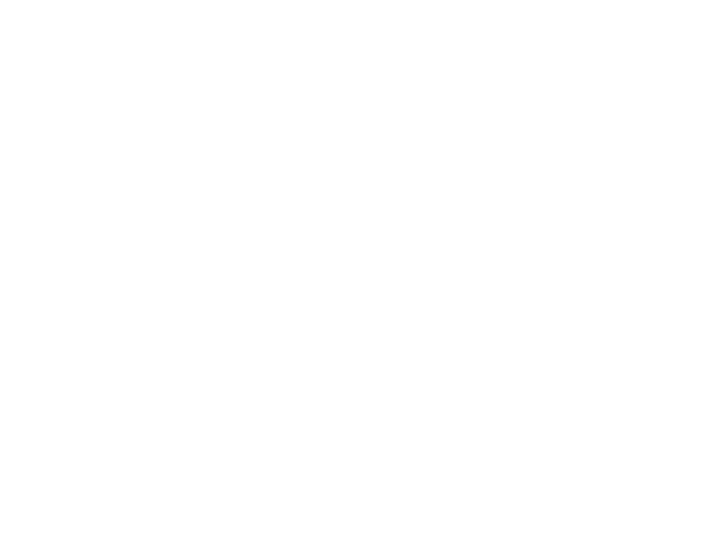

In [9]:
# Start application
from IPython.core.display import HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(dashboard)